## Hierarchical Wasserstein Alignment (HiWA)

_Aim:_ Decompose data into potential clusters and then find global alignment across two datasets by leveraging clustering structure.

_Paper describing HiWA:_ John Lee, Max Dabagia, E Dyer, C Rozell: Hierarchical Wasserstein Alignment for Multimodal Distributions, May 2019.

#### In this demo there are steps to:

- Dimensionality reduction to first simplify problem
- Clustering data to feed labels into HiWA
- Alignment between clusters and then global alignment with HiWA

In [67]:
# Import necessary packages

import numpy as np
from src import utils, hiwa
from sklearn.datasets import make_spd_matrix
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.manifold import Isomap
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from scipy.linalg import pinv
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline

### Example A - Synthetic Gaussians 

#### Step 0. Load data from numpy archive

In [262]:
with np.load(os.path.join('data', 'sg_demo.npz')) as dataz:
    X_te = dataz['X_te']
    T_te = dataz['T_te']
    X_tr = dataz['X_tr']
    T_tr = dataz['T_tr']

#### Step 1. Align data with HiWA

In [272]:
# Fit the model and transform the source dataset
t1 = time.time()

# This indicates to the model it should compute a low-d embedding with isomap, 
# and that the parameter datasets will not be normalized.
hwa = hiwa.HiWA(dim_red_method=Isomap(n_components=2), normalize=True)

# Fit the model, also passing in the correct rotation in Rgt since we can 
# calculate it in this case (for computing error metrics)
# Note that we can provide the low-d mapping for either the source or target; 
# the model will calculate whatever isn't provided
hwa.fit(X_te, T_te, X_tr, T_tr, Rgt=Rgt)

# Transform the dataset with the learned rotation
X_te_rec = hwa.transform(X_te)
t2 = time.time()
print('Time elapsed: {:.5} seconds'.format(t2 - t1))

Time elapsed: 0.57946 seconds


#### Step 2. Evaluate performance with 1NN target accuracy

In [273]:
# Evaluate nearest neighbors classification accuracy before alignment
nbrs = NearestNeighbors()
nbrs.fit(X_te)
idx = nbrs.kneighbors(X_tr, n_neighbors=1, return_distance=False).squeeze()
nn_hwa_prealign = (T_te[idx] == T_tr).sum() / T_tr.shape[0]
print('NN Accuracy (Before): {:.2%}'.format(nn_hwa_prealign))

# Evaluate nearest neighbors classification accuracy after alignment
nbrs = NearestNeighbors()
nbrs.fit(X_te_rec)
idx = nbrs.kneighbors(X_tr, n_neighbors=1, return_distance=False).squeeze()
nn_hwa = (T_te[idx] == T_tr).sum() / T_tr.shape[0]
print('NN Accuracy (After): {:.2%}'.format(nn_hwa))

NN Accuracy (Before): 26.00%
NN Accuracy (After): 94.75%


#### Step 3. Visualize results

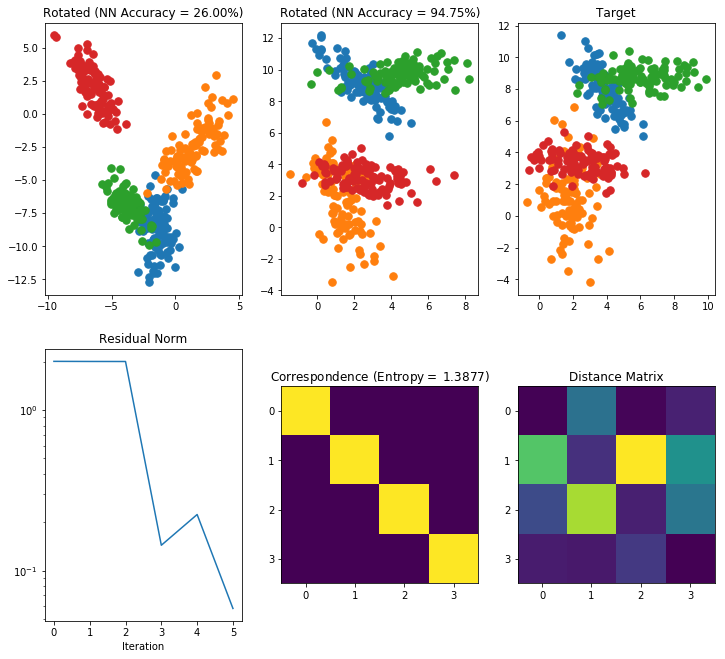

In [274]:
# Plot the results, plus some diagnostics
plt.figure(figsize=(12, 11))
plt.subplot(2, 3, 1)
plt.title('Rotated (NN Accuracy = {:.2%})'.format(nn_hwa_prealign))
utils.plot_2d_clusters(X_te, T_te)
plt.subplot(2, 3, 2)
plt.title('Rotated (NN Accuracy = {:.2%})'.format(nn_hwa))
utils.plot_2d_clusters(X_te_rec, T_te)
plt.subplot(2, 3, 3)
plt.title('Target')
utils.plot_2d_clusters(X_tr, T_tr)
ax = plt.subplot(2, 3, 4)
plt.plot(hwa.diagnostics['Rg_norm'])
ax.set_yscale('log')
plt.title('Residual Norm')
plt.xlabel('Iteration')
plt.subplot(2, 3, 5)
plt.imshow(hwa.P)
plt.xticks(np.arange(4))
plt.yticks(np.arange(4))
plt.title('Correspondence (Entropy$ = $ %.4f)' %(-np.sum(hwa.P * np.log(hwa.P))))
plt.subplot(2, 3, 6)
plt.xticks(np.arange(4))
plt.yticks(np.arange(4))
plt.title('Distance Matrix')
c = plt.imshow(hwa.diagnostics['C'])

### Example B - Motor cortex during reaching movements (NHP)
_Data collected by:_ Matthew Perich, Lee Miller Lab (Northwestern)

#### Step 0. Load datasets and reach direction labels

In [2]:
# Load the datasets from a .mat file
T_te, T_tr, X_te, X_tr, Y_te, Y_tr = utils.load_data(os.path.join('data', 'mihi_demo.mat'))
T_te, T_tr = T_te.squeeze(), T_tr.squeeze()

#### Step 1. Apply initial dimensionality reduction

In [3]:
# Apply initial dimensionality reduction (n_components)
Y_te_3d = FactorAnalysis(n_components=3).fit_transform(utils.remove_const_cols(Y_te))
X_tr_3d = utils.map_X_3D(X_tr)
X_transform = np.linalg.pinv(X_tr_3d) @ X_tr

#### Step 2. Align data with HiWA

In [4]:
# Fit the model and transform the source dataset
t1 = time.time()

# This indicates to the model it should compute a low-d embedding with isomap, 
# and that the parameter datasets will not be normalized
hwa = hiwa.HiWA(dim_red_method=Isomap(n_components=2, n_neighbors=12), normalize=True)

# Fit the model, also passing in the correct rotation in Rgt since we can 
# calculate it in this case (for computing error metrics)
# Note that we can provide the low-d mapping for either the source or target; 
# the model will calculate whatever isn't provided
hwa.fit(Y_te_3d, T_te, X_tr_3d, T_tr, Y_transform=X_transform, Rgt=utils.LS_oracle(utils.map_X_3D(X_te), Y_te_3d))

# Transform the dataset with the learned rotation
Y_te_rec = hwa.transform(Y_te_3d)
t2 = time.time()
print('Time elapsed: {:.5} seconds'.format(t2 - t1))

Time elapsed: 8.0 seconds


#### Step 3. Evaluate performance metrics (R2 and target accuracy)

In [6]:
# Evaluate decoding accuracy after alignment
r2_hwa = utils.eval_R2(Y_te_rec[:,0:2], X_te)
print('R2 Value: {:.4}'.format(r2_hwa))

# Evaluate nearest neighbors classification accuracy before alignment
nbrs = NearestNeighbors()
nbrs.fit(Y_te_3d)
idx = nbrs.kneighbors(X_tr_3d, n_neighbors=1, return_distance=False).squeeze()
nn_hwa_prealign = (T_te[idx] == T_tr).sum() / T_tr.shape[0]
print('NN Accuracy (Before): {:.2%}'.format(nn_hwa_prealign))

# Evaluate nearest neighbors classification accuracy after alignment
nbrs = NearestNeighbors()
nbrs.fit(Y_te_rec)
idx = nbrs.kneighbors(X_tr_3d, n_neighbors=1, return_distance=False).squeeze()
nn_hwa = (T_te[idx] == T_tr).sum() / T_tr.shape[0]
print('NN Accuracy (After): {:.2%}'.format(nn_hwa))

R2 Value: 0.6307
NN Accuracy (Before): 24.40%
NN Accuracy (After): 52.65%


#### Step 4. Visualize results

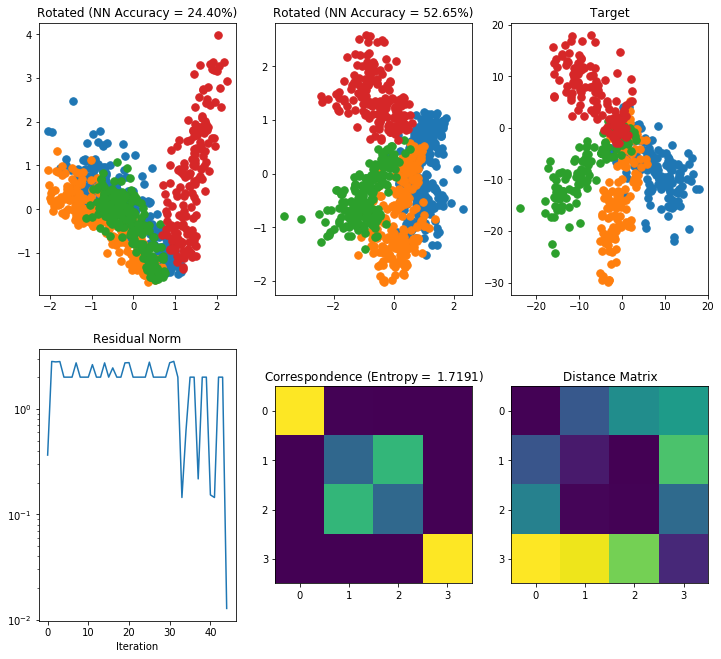

In [7]:
# Plot the results, plus some diagnostics
plt.figure(figsize=(12, 11))
plt.subplot(2, 3, 1)
plt.title('Rotated (NN Accuracy = {:.2%})'.format(nn_hwa_prealign))
utils.plot_2d_clusters(Y_te_3d, T_te)
plt.subplot(2, 3, 2)
plt.title('Rotated (NN Accuracy = {:.2%})'.format(nn_hwa))
utils.plot_2d_clusters(Y_te_rec, T_te)
plt.subplot(2, 3, 3)
plt.title('Target')
utils.plot_2d_clusters(X_tr, T_tr)
ax = plt.subplot(2, 3, 4)
plt.plot(hwa.diagnostics['Rg_norm'])
ax.set_yscale('log')
plt.title('Residual Norm')
plt.xlabel('Iteration')
plt.subplot(2, 3, 5)
plt.imshow(hwa.P)
plt.xticks(np.arange(4))
plt.yticks(np.arange(4))
plt.title('Correspondence (Entropy$ = $ %.4f)' %(-np.sum(hwa.P * np.log(hwa.P))))
plt.subplot(2, 3, 6)
plt.xticks(np.arange(4))
plt.yticks(np.arange(4))
plt.title('Distance Matrix')
c = plt.imshow(hwa.diagnostics['C'])